In [1]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from scipy.stats import pearsonr
from scipy.spatial import distance
from scipy.cluster import hierarchy
from scipy import stats
from multiprocessing import Pool
import os
import scanpy as sc
from matplotlib.colors import LinearSegmentedColormap

In [5]:
'load gene module'
cell_2019_gene_module = pd.read_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/gene_list/Cell_2019_gene_module.csv')

'load data'
tpm_log = pd.read_csv('/home/qukun/ccp1997/GBM_10X/patch_seq/batch3/tpm_merge_log.csv',index_col=0)

EPSC_cells = ['O12301','021804','021805','021806','021808','030301','030704','030705',
             '030706','030709','031001','031003','031004','031007','031008','031101',
             '032101','032102','032103',
             '033003','033004','033102','033104','033105','033106','033107','033110']

'load prediction'
prediction = pd.read_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/patch_seq/patch_seq_prediction.csv',index_col=0)     
prediction.index = [ item.split('X')[1] for item in prediction.index]

scarches_prediction = pd.read_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/scarches_hvg3000_remove_neurons/prediction.csv',index_col=0)
scarches_prediction.index = [ '0'+str(item) for item in scarches_prediction.index]

In [9]:
'marker genes heatmap'
tpm_log = pd.read_csv('/home/qukun/ccp1997/GBM_10X/patch_seq/batch3/tpm_merge_log.csv',index_col=0)
cells = np.intersect1d(prediction.index,EPSC_cells).tolist() +\
['021801', '021802', '030702']\
+ ['031103']+ ['031703'] + ['030601','031701'] + ['031705','031706','033001'] + prediction.loc[prediction['predicted.id'] == 'Exhausted CD8T' ].index.tolist()
tpm_log = tpm_log[cells]

'z-score'
tpm_log_z_score = pd.DataFrame(index = tpm_log.index,columns=tpm_log.columns)
for item in tpm_log_z_score.index:
    tpm_log_z_score.loc[item] = stats.zscore(tpm_log.loc[item])
tpm_log_z_score[list(tpm_log_z_score.columns)]=tpm_log_z_score[list(tpm_log_z_score.columns)].astype(float) 
tpm_log_z_score = tpm_log_z_score.fillna(0)

for_heatmap = tpm_log_z_score

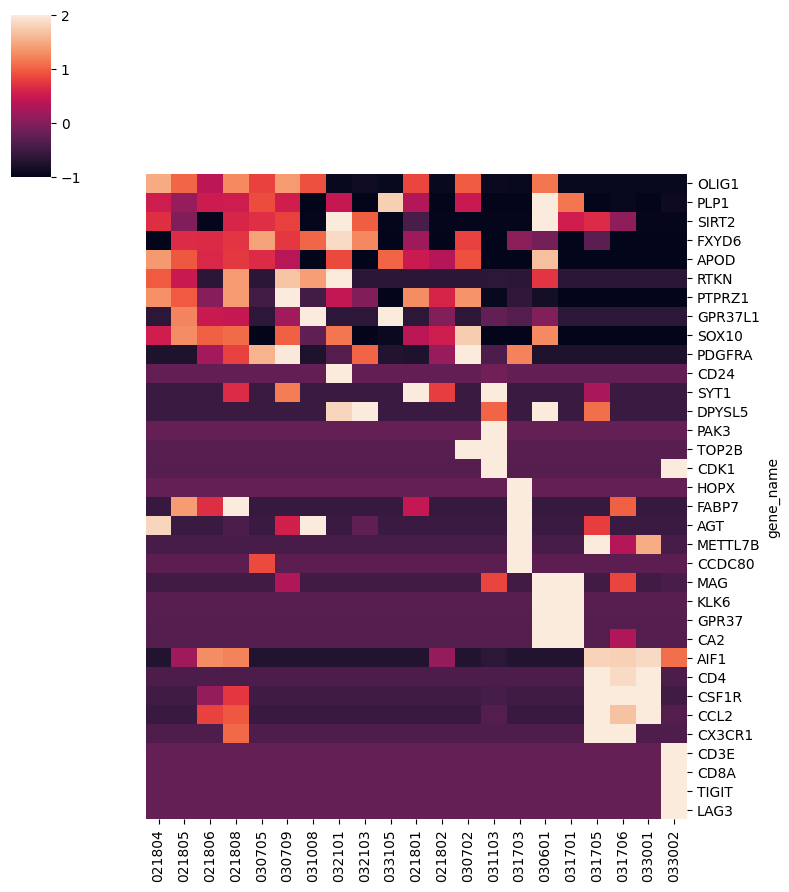

In [10]:
genes = ['OLIG1','PLP1','SIRT2','FXYD6','APOD','RTKN','PTPRZ1','GPR37L1','SOX10','PDGFRA'] + ['CD24','SYT1','DPYSL5','PAK3','TOP2B','CDK1'] + ['HOPX','FABP7','AGT','METTL7B','CCDC80'] +[ 'MAG','KLK6','GPR37','CA2','AIF1','CD4','CSF1R','CCL2','CX3CR1','CD3E','CD8A','TIGIT','LAG3']
sns.clustermap(for_heatmap.loc[genes], vmax=2, vmin=-1,row_cluster=False,col_cluster=False,figsize=(8,9))
plt.savefig('/home/qukun/ccp1997/GBM_10X/ng_revised/figure/result_5/patch_seq_marker_heatmap_v2.pdf')


In [11]:
'Data quality'

'Data quality'

In [15]:
select_cells = for_heatmap.columns.tolist()

data_quality = pd.DataFrame(np.sum(tpm_log != 0),columns=['features'])
data_quality['cells'] = data_quality.index

data_quality = data_quality.loc[select_cells]

color_ax = sns.heatmap(pd.DataFrame(data_quality['features']),cmap='Reds',xticklabels=False,yticklabels=False,vmin=-500,vmax=4500)
im = color_ax.collections[0]
color_rgba_values = im.cmap(im.norm(im.get_array()))

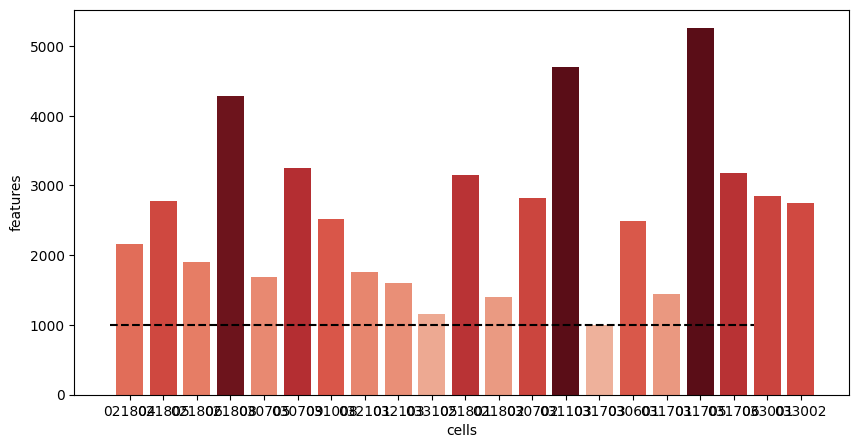

In [16]:
plt.figure(figsize=(10,5))
sns.barplot(x="cells", y="features", data=data_quality,
                 palette=color_rgba_values)
plt.hlines(y=1000,xmin=-0.6,xmax=18.6,linestyles='dashed',colors='black')
plt.savefig('/home/qukun/ccp1997/GBM_10X/ng_revised/figure/result_5/patch_seq_data_quality_21_cells.pdf')

In [ ]:
'transfer anchor'

In [1928]:
from sklearn.neighbors import NearestNeighbors

In [2196]:
'load anchor'
umap = pd.read_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/scarches_hvg3000_remove_neurons/UMAP.csv',index_col=0)

anchors = pd.read_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/patch_seq/patch_EPSC_anchors.csv',index_col=0)
anchors_name = pd.DataFrame(columns=anchors.columns,index=anchors.index)

cell_rank = pd.read_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/patch_seq/patch_EPSC_seq_prediction.csv',index_col=0)   
cell_rank.index = [ item.split('X')[1] for item in cell_rank.index]

anchor_ranking = pd.read_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/patch_seq/anchor_ranking.csv',index_col=0)

In [2197]:
for item in anchors.index:
    anchors_name.loc[item] = [anchor_ranking.index[int(anchors.loc[item]['cell1'] - 1)],cell_rank.index[int(anchors.loc[item]['cell2'] - 1)],anchors.loc[item]['score']]
    
anchors_cells = pd.DataFrame(index = list(set(anchors_name['cell2'])),columns=['anchor_cell'])
for cell in anchors_cells.index:
    result = anchors_name.loc[anchors_name['cell2'] == cell].loc[anchors_name.loc[anchors_name['cell2'] == cell]['score'] == np.max(anchors_name.loc[anchors_name['cell2'] == cell]['score'])]['cell1'].tolist() 
    anchors_cells.loc[cell]['anchor_cell'] = result

select_cells = []
for cell in anchors_cells.index:
    if len(np.intersect1d(anchors_cells.loc[cell]['anchor_cell'],umap.index)) != 0:
        select_cells.append(cell)

anchors_cells = anchors_cells.loc[select_cells]
other_cells = pd.DataFrame(index=np.setdiff1d(cell_rank.index,anchors_cells.index),columns=['anchor_cell'])

In [2200]:
for cell in other_cells.index:
    
    for_knn = tpm_log[cell_rank.index]

    for_knn = for_knn[np.setdiff1d(for_knn.columns,other_cells.index).tolist() + [cell]]

    for_knn = for_knn.loc[np.sum(for_knn,axis=1) != 0]

    X = np.array(for_knn.T.values)
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree',n_jobs=20).fit(X)
    knn_results = nbrs.kneighbors_graph(X).toarray()
    knn_results = pd.DataFrame(knn_results,index=for_knn.columns,columns=for_knn.columns)

    tmp_result = anchors_cells.loc[np.setdiff1d(knn_results.columns[knn_results.loc[cell] == 1],cell)]

    other_cells.loc[cell]['anchor_cell'] = list(tmp_result.iloc[0]['anchor_cell'])

In [2203]:
UMAP_1 = []
UMAP_2 = []
for cell in anchors_cells.index:
    UMAP_1.append(np.mean(umap.loc[np.intersect1d(anchors_cells.loc[cell][0],umap.index)])['UMAP_1'] + ((1-(-1))*np.random.random() + (-1))*0.5)
    UMAP_2.append(np.mean(umap.loc[np.intersect1d(anchors_cells.loc[cell][0],umap.index)])['UMAP_2'] + ((1-(-1))*np.random.random() + (-1))*0.5)
anchors_cells['UMAP_1'] = UMAP_1
anchors_cells['UMAP_2'] = UMAP_2

UMAP_1 = []
UMAP_2 = []
for cell in other_cells.index:
    UMAP_1.append(np.mean(umap.loc[np.intersect1d(other_cells.loc[cell][0],umap.index)])['UMAP_1'] + ((1-(-1))*np.random.random() + (-1))*0.5) 
    UMAP_2.append(np.mean(umap.loc[np.intersect1d(other_cells.loc[cell][0],umap.index)])['UMAP_2'] + ((1-(-1))*np.random.random() + (-1))*0.5) 
other_cells['UMAP_1'] = UMAP_1
other_cells['UMAP_2'] = UMAP_2

merge_umap = pd.concat([anchors_cells,other_cells])

In [2204]:
meta_data = pd.read_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/RNA_matrix/all_cells_meta_data.csv',index_col=0)

clust_colors = {'TAM1':'#17728C','TAM2':'#C1EDF6','TAM3':'#C5E5BD','TAM4':'#89CFC5','TAM5':'#AA5FAC','Monocytes':'#748EBF','DC cells':'#00C8FB',\
                'Oligodendrocyte':'#AE958C',\
                'B cells':'#ECD157', 'Plasma cells':'#DABB57',\
                'Treg cells':'#fc912a','T-IFI6':'#FF6666',\
                'Cytotoxic CD8T':'#FD9DC6','Exhausted CD8T':'#eedce4',\
                'CD4T':'#FFB3A1','T-HSPA1A':'#FFD9CE',\
                'NK cells':'#FF3D73',\
                'MES-like':'#C6008D','AC-like':'#FED100','OPC-like':'#00A555','NPC-like':'#16CB55',\
                'Excitatory neurons':'#4C8266','Inhibitory neurons':'#3D6666',\
                'Pericyte':'#C83726','VSMCs':'#972826','Endo':'#F51F1A'}

umap['cluster'] = meta_data.loc[umap.index]['annotation']
clust_color_list = [ clust_colors[item]  for item in umap['cluster']]
umap['cluster_color'] = clust_color_list

In [2205]:
OPC_cells = umap.loc[umap['cluster'] == 'OPC-like'].index.tolist()
Other_cells = umap.loc[umap['cluster'] != 'OPC-like'].index.tolist()

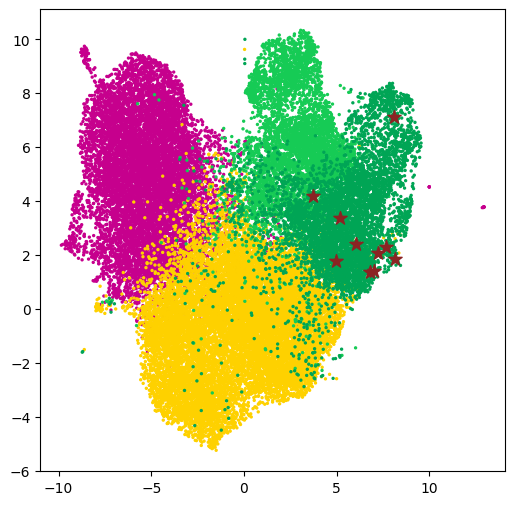

In [2217]:
plt.figure(figsize=(6,6))
plt.scatter(x=umap.loc[Other_cells]['UMAP_1'],y=umap.loc[Other_cells]['UMAP_2'],c=umap.loc[MES_AC_cells]['cluster_color'],s=1.5, rasterized=True)
plt.scatter(x=umap.loc[OPC_cells]['UMAP_1'],y=umap.loc[OPC_cells]['UMAP_2'],c=umap.loc[OPC_cells]['cluster_color'],s=1.5, rasterized=True)
plt.scatter(x=merge_umap['UMAP_1'],y=merge_umap['UMAP_2'],s=100,color='#8B2323',marker='*')
plt.savefig('/home/qukun/ccp1997/GBM_10X/ng_revised/figure/result_5/patch_seq_umap_10_cells.pdf',dpi=500)      